In [18]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import sklearn
import re
from scipy.spatial.distance import jaccard
from sklearn.cluster import SpectralClustering as cluster
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize

In [19]:
def wordCount(word, words):
    #add one to never return 0
    return (list(words).count(word))

In [20]:
def wordImportance(messages):
    remove = set(stopwords.words('english'))
    tfIdfVectorizer=TfidfVectorizer(use_idf=True, stop_words = remove)
    tfIdf = tfIdfVectorizer.fit_transform(messages)
    df = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
    df = df.sort_values('TF-IDF', ascending=False)
    return df

In [21]:
def jaccard_similarity(A, B):
    #Find intersection of two sets
    nominator = A.intersection(B)

    #Find union of two sets
    denominator = A.union(B)

    #Take the ratio of sizes
    similarity = len(nominator)/len(denominator)
    
    return similarity

def getDistanceMatrix(thread):
    matrix = []
    for i in range(0,len(thread)):
        row = []
        for j in range(0,len(thread)):
            distance = jaccard_similarity(set(thread[i]),set(thread[j]))
            row.append(distance)
        matrix.append(row)
    return matrix

In [22]:
def is_ascii(s):
    return all(ord(c) < 128 for c in s)

def cleanData(messages):
    for i in range(0,len(messages)):
        try:
            filtered = re.sub(r'[\(, \)]', ' ', messages.iloc[i])
            filtered = re.sub(r'[\!]', '', filtered)
            filtered = re.sub(r'[^\w\s\!]', '', filtered)
            messages.iloc[i] = filtered
        except:
            messages.iloc[i] = ""
        
        if is_ascii(messages.iloc[i]) == False:
             messages.iloc[i] = ""
        messages.iloc[i] = messages.iloc[i].split(" ")
        
    return messages

# Load and Clean Data

In [23]:
#Load Data
data = pd.read_csv("Ansar1Clean.csv", index_col=0)

In [24]:
#Get thread
threads = data["ThreadID"].unique()

longThreads = []
for i in range(0,len(threads)):
    thread = data[data["ThreadID"]== threads[i]]
    if len(thread) > 50:
        longThreads.append(threads[i])
longThreads

[1197, 813, 1525, 3531, 4444, 1893, 2140, 11207, 13591, 15756]

In [35]:

thread = data[data["ThreadID"]== longThreads[0]]

thread = thread.reset_index(drop = True)

#get all messages
messages = thread["Message"].copy()

#clean data
clean = cleanData(messages)
clean

0      [Iraq, Office, of, the, Assistant, Secretary, ...
1      [Afghanistan, 042309, burnleyexpress, Foulridg...
2      [AsSalaamu, alaikum, Yet, another, Crusader, d...
3      [Afghanistan, defense, news, 042409, theglobea...
4      [Iraq, Defense, Link, 042509, MNF, MNDN, Soldi...
                             ...                        
202    [Iraq, 041309, Reuters, Four, US, soldiers, wo...
203    [Iraq, Office, of, the, Assistant, Secretary, ...
204    [Iraq, Office, of, the, Assistant, Secretary, ...
205    [IraqAfghanistan, , Allah, Akbar, 175, killed,...
206    [Iraq, Office, of, the, Assistant, Secretary, ...
Name: Message, Length: 207, dtype: object

# Cluster Data

In [36]:
matrix = getDistanceMatrix(clean.to_numpy())

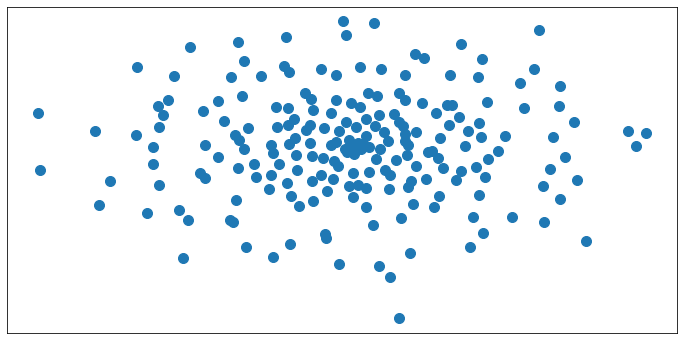

In [37]:
dt = [('len', float)]
A = np.array(matrix)
A = A.view(dt)

G = nx.from_numpy_matrix(A)

plt.figure(figsize = (12,6))
pos = nx.drawing.nx_agraph.graphviz_layout(G, prog='neato')
G.remove_edges_from(list(G.edges()))
G = nx.drawing.nx_pylab.draw_networkx(G,pos=pos,node_size = 100,alpha = 1,with_labels=False)

# Analysis

In [38]:
coords = np.array(list(pos.values()))
x = coords.T[0]
y = coords.T[1]

In [39]:
scaler = StandardScaler()
scaler.fit(coords)
normCoords = scaler.transform(coords)

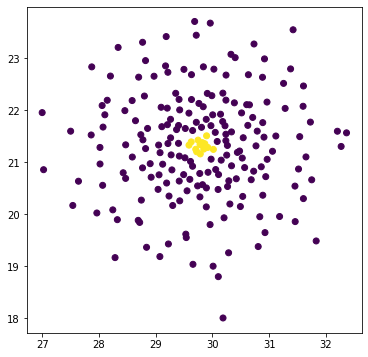

In [40]:
clusters = DBSCAN(eps=.15, min_samples=5).fit(normCoords)
plt.figure(figsize = (6,6))
plt.scatter(x,y, c= clusters.labels_)

In [41]:
labels = clusters.labels_
idx = np.where(labels == 0)

dense = thread["Message"][idx[0]]
dense

44     Afghanistan: 06/08/09 NDCF: Canadian soldier k...
94     Afghanistan defense News 07/06/09 : DoD Identi...
112    Afghanistan defense News 07/17/09 MoD: Soldier...
116    61 Soldiers Died In Iraq And Afghanistan This ...
120    Jazakallahu khair my brother Acer007, keep upd...
147    Afghanistan Defense News 08/17/09 (Reuters) - ...
155                        Allahu Akbar. 21 sent to hell
160    Afghanistan Defense News Two British soldiers ...
162    Afghanistan Defense News Warsaw, Sep 5 (DPA) O...
165    Iraq Defense News The U.S. military says four ...
166                  Allahu Akbar!!! all praise to allah
171    Iraq Defense News Blackhawk crash kills US ser...
175    Afghanistan Defense News A suicide bomber ramm...
203    Iraq Office of the Assistant Secretary of Defe...
Name: Message, dtype: object

In [42]:
#get word importance
importance = wordImportance(dense)
importance.head(25)

,TF-IDF
canadian,0.320059
09,0.220735
device,0.220735
explosive,0.220735
killed,0.218822
22e,0.217914
06,0.217914
ndcf,0.217914
08,0.217914
bataillon,0.217914


In [43]:
cleanData(dense)
allWords = np.char.lower(np.concatenate(dense.to_numpy()))
uniqueWords = list(set(allWords) - set(stopwords.words('english')))

counts = []
words = []

for i in range(0,len(uniqueWords)):
    words.append(uniqueWords[i])
    counts.append(wordCount(uniqueWords[i], allWords))

In [44]:
allCounts = pd.DataFrame(np.array([words,counts]).T,columns = ["words","counts"])
allCounts = allCounts.sort_values(by = ["counts"], ascending=False)
allCounts.head(25)

,words,counts
453,afghanistan,96
357,killed,94
759,war,9
308,improvised,9
40,explosive,9
46,spokesman,9
1049,others,9
900,five,9
96,casualties,9
457,number,9


Analysis of words, sentences, posts
Seperate people analysis 
Sentiment spread from person to person